In [1]:
import pandas as pd
from IPython.display import JSON
import pylab
import json
%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid') # TODO: what did this do?
import numpy as np
from IPython.core import display
import psycopg2
import os
homedir = os.getenv("HOME")
with open(homedir + "/.pgpass",'r') as pgfile:
    pgdat = pgfile.read().strip().split(":")
    pgurl = pgdat[0]
    pgport = pgdat[1]
    pgdb = pgdat[2]
    pguser = pgdat[3]
    pgpass = pgdat[4]

%load_ext sql
from sqlalchemy import create_engine
# sql info: https://github.com/catherinedevlin/ipython-sql
# on error `pip install ipython-sql`
#uncomment for remote
#pgport=3333
pgport=5432
engine = create_engine('postgresql://postgres@localhost:%i/postgres' % pgport)
db = psycopg2.connect(host=pgurl, database=pgdb, user=pguser,password=pgpass,port=pgport)

In [2]:
def qry(q):
  return pd.read_sql_query(con = db, sql = q)
# pd.set_option("max_colwidth", None)
# pd.set_option('display.max_columns', None)
# pd.set_option("display.latex.repr", False)
# pd.set_option("display.latex.escape", True)

def iDisplay(v):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, "max_colwidth", None):
        display.display(v)


Count number of uploaded APK files

In [3]:
%%sql postgresql://postgres@localhost:$pgport/postgres
select
    (select count(*) from apks where apkname not like 'jar_%' and apkname not like 'spec_%') as apk_count,
    (select count(*) from apks) as blob_count, 
    (select count(*) from inputs) as input_count, 
    (select count(*) from jobs) as job_count, 
    (select count(*) from resultdata) as result_data_count, 
    (select count(*) from results) as result_count

1 rows affected.


apk_count,blob_count,input_count,job_count,result_data_count,result_count
47,49,1,1090,1336,1082


In [4]:
%%sql -- count locations by pattern
select count(*), cast(jobs.config::json->'tag'->'heuristicType' as varchar) as category from jobs group by category

 * postgresql://postgres@localhost:5432/postgres
5 rows affected.


count,category
55,"""SensitiveDerefFieldCausedSynch"""
291,"""Disallow.I_CIEnter_Dialogdismiss"""
155,"""Disallow.I_CIEnter_AsyncTaskexecute"""
31,"""SensitiveDerefFieldCausedFinish"""
558,"""SensitiveDerefCallinCaused"""


Track Total Jobs
----------------
After running the cells above with shift-enter, the cell below may be run repeatedly to check the job status.

In [5]:
%%sql --    # Show jobs and statuses
select 
    (select count(*) from jobs where status = 'completed') as Completed_Jobs,
    (select count(*) from jobs where status = 'new') as New_Jobs,
    (select count(*) from jobs where status = 'paused') as Paused_Jobs,
    (select count(*) from jobs) as Total_Jobs,
    (select count(*) from jobs where status = 'acquired') as Acquired_jobs,
    (select count(id) from jobs 
       where stderr like '%Exception%no active body present for method%') as Body_Exception,
    (select count(id) from jobs where stderr like '%an implementation is missing%') as unimplemented,
    (select count(id) from jobs where stderr like '%Exception%') as Exception,
    (select count(id) from jobs where stderr like '%no libz3java in java.library.path%') as path_exception,
    (select count(id) from jobs where stderr like '%Failed to parse reflective type reference%') as Refl_exception,
    (select count(id) from jobs where status like 'failed%' and status not like 'failed: Subprocess Timeout') as worker_failure,
    (select count(id) from jobs where status like 'failed: Subprocess Timeout') as subprocess_timeout,
    (select count(id) from jobs where stdout like '%empty pred location%') as possible_cg_unsound,
    (select count(id) from jobs where stderr like '%OutOfMemory%') as memory
 

 * postgresql://postgres@localhost:5432/postgres
1 rows affected.


completed_jobs,new_jobs,paused_jobs,total_jobs,acquired_jobs,body_exception,unimplemented,exception,path_exception,refl_exception,worker_failure,subprocess_timeout,possible_cg_unsound,memory
1051,0,0,1090,2,0,0,0,0,0,10,27,0,0


In [5]:
%%sql -- get all uploaded app names
select apkname from apks;

 * postgresql://postgres@localhost:5432/postgres
49 rows affected.


apkname
/fdroid/be.digitalia.fosdem/2.1.1/apk/be.digitalia.fosdem_1900211.apk
/fdroid/org.yuttadhammo.BodhiTimer/6.3.0/apk/org.yuttadhammo.BodhiTimer_98.apk
/fdroid/org.liberty.android.fantastischmemo/10.11.7/apk/org.liberty.android.fantastischmemo_237.apk
/fdroid/de.syss.MifareClassicTool/4.0.4/apk/de.syss.MifareClassicTool_62.apk
/fdroid/org.scoutant.blokish/3.4/apk/org.scoutant.blokish_22.apk
/fdroid/de.jkliemann.parkendd/1.2.8/apk/de.jkliemann.parkendd_33.apk
/fdroid/com.nutomic.syncthingandroid/1.23.0/apk/com.nutomic.syncthingandroid_4334.apk
/fdroid/com.owncloud.android/3.0.1/apk/com.owncloud.android_30000001.apk
/fdroid/org.mariotaku.twidere/4.1.8/apk/org.mariotaku.twidere_517.apk
/fdroid/com.asksven.betterbatterystats/3.3.1/apk/com.asksven.betterbatterystats_107.apk


In [6]:
#Estimate time until completion of all jobs

totTime = %sql select now() - min(started) from jobs;
completedJobs = %sql select count(*) from jobs where status = 'completed';
timeoutJobs = %sql select count(*) from jobs where status like 'failed%';
newJobs = %sql select count(*) from jobs where status = 'new';
if (completedJobs[0][0] + timeoutJobs[0][0]) != 0:
    avgJobTime = totTime[0][0] / (completedJobs[0][0] + timeoutJobs[0][0])
    print("average time per job: " + str(avgJobTime))
    print("est remaining time: " + str(avgJobTime * newJobs[0][0]))
else:
    print("Please wait for one job to complete for time estimate")

 * postgresql://postgres@localhost:5432/postgres
1 rows affected.
 * postgresql://postgres@localhost:5432/postgres
1 rows affected.
 * postgresql://postgres@localhost:5432/postgres
1 rows affected.
 * postgresql://postgres@localhost:5432/postgres
1 rows affected.
average time per job: 2:17:43.735288
est remaining time: 0:00:00


In [7]:
# find and print an exception -- These are considered "timeouts" in the paper.
outs = %sql select stderr,config from jobs where stderr like '%Exception%' limit 1;
for out in outs:
    print(out[1])
    print(out[0])


 * postgresql://postgres@localhost:5432/postgres
0 rows affected.


In [9]:
%%sql -- list each result summary and apk counts
select cast(results.result::json->'summary' as varchar) as summary, cast(jobs.config::json->'apkPath' as varchar) as benchmark,count(*) from results inner join jobs on jobs.id=results.jobid group by summary,benchmark order by benchmark,summary desc

 * postgresql://postgres@localhost:5432/postgres
110 rows affected.


summary,benchmark,count
"""\""Unreachable\""""","""${baseDir}/fdroid/be.digitalia.fosdem/2.1.1/apk/be.digitalia.fosdem_1900211.apk""",7
"""\""Timeout\""""","""${baseDir}/fdroid/be.digitalia.fosdem/2.1.1/apk/be.digitalia.fosdem_1900211.apk""",2
"""\""Witnessed\""""","""${baseDir}/fdroid/ch.blinkenlights.android.vanilla/1.2.2/apk/ch.blinkenlights.android.vanilla_12200.apk""",6
"""\""Unreachable\""""","""${baseDir}/fdroid/ch.blinkenlights.android.vanilla/1.2.2/apk/ch.blinkenlights.android.vanilla_12200.apk""",3
"""\""Timeout\""""","""${baseDir}/fdroid/ch.blinkenlights.android.vanilla/1.2.2/apk/ch.blinkenlights.android.vanilla_12200.apk""",3
"""\""Ijava.lang.AssertionError: assertion failed: Exception: Too many locations found: \\n \""""","""${baseDir}/fdroid/ch.blinkenlights.android.vanilla/1.2.2/apk/ch.blinkenlights.android.vanilla_12200.apk""",1
"""\""Unreachable\""""","""${baseDir}/fdroid/com.android.keepass/2.6.8/apk/com.android.keepass_215.apk""",3
"""\""Timeout\""""","""${baseDir}/fdroid/com.android.keepass/2.6.8/apk/com.android.keepass_215.apk""",5
"""\""Witnessed\""""","""${baseDir}/fdroid/com.asksven.betterbatterystats/3.3.1/apk/com.asksven.betterbatterystats_107.apk""",5
"""\""Unreachable\""""","""${baseDir}/fdroid/com.asksven.betterbatterystats/3.3.1/apk/com.asksven.betterbatterystats_107.apk""",13


Check result consistency
========================

If workers are killed while running the experiments, jobs can be left abandoned.  The following queries help find abandoned jobs.

In [11]:
%%sql -- Find completed jobs where no results exist and no error occurred
select jobs.id from jobs where jobs.id not in (select results.jobid from results) and jobs.status = 'completed' and jobs.stderr not like '%Exception%';

 * postgresql://postgres@localhost:5432/postgres
0 rows affected.


id


In [12]:
%%sql -- Find new/paused jobs with results
select jobs.id from jobs where jobs.id in (select results.jobid from results) and (jobs.status = 'paused' or jobs.status = 'new');

 * postgresql://postgres@localhost:5432/postgres
0 rows affected.


id


In [13]:
%%sql -- check that each location/qry pair only has one result (should detect duplicat runs)
select count(*),qry,loc as num from results group by qry,loc order by count(*) desc limit 1;

 * postgresql://postgres@localhost:5432/postgres
1 rows affected.


count,qry,num
1,"{""methodName"":""android.view.View onCreateView(android.view.LayoutInflater,android.view.ViewGroup,android.os.Bundle)"",""line"":122,""t"":""ReceiverNonNull"",""matcher"":""java.lang.Object getSystemService(java.lang.String)"",""className"":""com.darshancomputing.BatteryIndicatorPro.CurrentInfoFragment""}","{""$type"":""edu.colorado.plv.bounder.ir.AppLoc"",""method"":[""android.view.View onCreateView(android.view.LayoutInflater,android.view.ViewGroup,android.os.Bundle)"",""com.darshancomputing.BatteryIndicatorPro.CurrentInfoFragment"",[""com.darshancomputing.BatteryIndicatorPro.CurrentInfoFragment"",""android.view.LayoutInflater"",""android.view.ViewGroup"",""android.os.Bundle""],[""[{\""name\"":\""@this\"",\""localType\"":\""com.darshancomputing.BatteryIndicatorPro.CurrentInfoFragment\""}]"",""[{\""name\"":\""@parameter0\"",\""localType\"":\""android.view.LayoutInflater\""}]"",""[{\""name\"":\""@parameter1\"",\""localType\"":\""android.view.ViewGroup\""}]"",""[{\""name\"":\""@parameter2\"",\""localType\"":\""android.os.Bundle\""}]""]],""line"":{""id"":122,""desc"":""SerializedIRLineLoc(122,line: 122 $r17 = virtualinvoke $r5.<android.app.Activity: java.lang.Object getSystemService(java.lang.String)>(\""power\""),1038598525)"",""ident"":849063257},""isPre"":true}"


Runtime Stats
=============

Plot statistics on running experiments.  Note, at least one job must have finished

 * postgresql://postgres@localhost:5432/postgres
1082 rows affected.


Text(0.5, 0, 'time (hrs)')

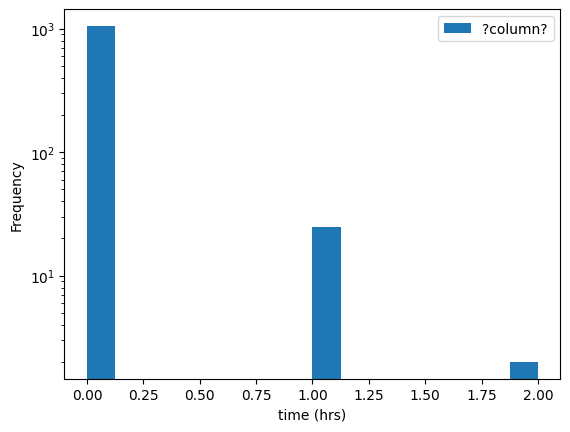

In [14]:
queryTime = %sql select querytime/60/60 from results;
tplt = queryTime.DataFrame().plot.hist(bins=16)
tplt.set_yscale('log')
# tplt.set_xscale('log')
tplt.set_xlabel('time (hrs)')
# split this into proven and witnessed

In [15]:
cfg = %sql select jobs.config from results join jobs on jobs.id = results.jobid where querytime > 6*60*60 limit 1;
if len(cfg) > 0:
    print(cfg[0][0])

 * postgresql://postgres@localhost:5432/postgres
0 rows affected.


 * postgresql://postgres@localhost:5432/postgres
1051 rows affected.


Text(0.5, 0, 'time (min)')

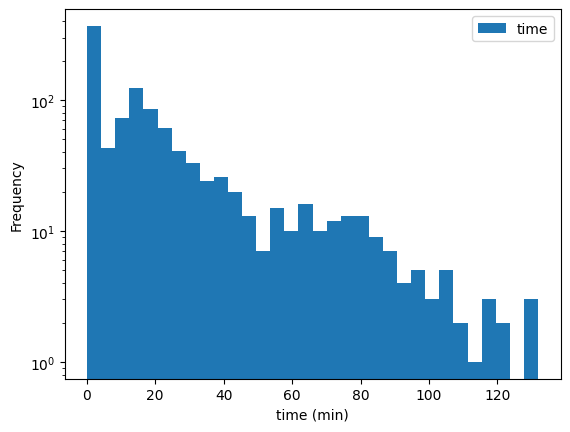

In [16]:
# Job runtimes
runtimes = %sql select ended - started as time from jobs where ended is not NULL;
runtimesDF = runtimes.DataFrame()
runtimesDF['time'] = runtimesDF['time'].apply(lambda x: x.total_seconds() / (60))
tplt = runtimesDF.plot.hist(bins=32)
tplt.set_yscale('log')
tplt.set_xlabel('time (min)')

 * postgresql://postgres@localhost:5432/postgres
1051 rows affected.


/tmp/ipykernel_1218/1841651425.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(rtvtDF['started'], rtvtDF['time'], marker='*', linestyle='')


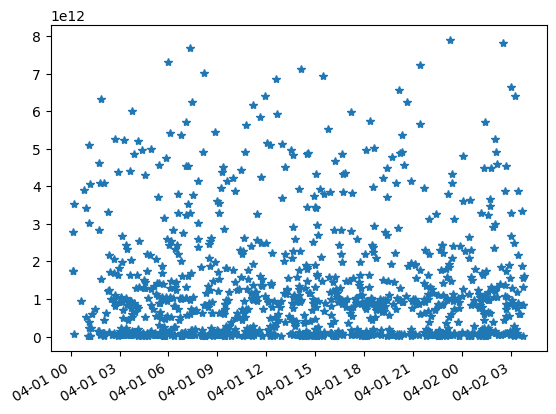

In [17]:
# Plot job time trend
rtvt = %sql select started, ended - started as time from jobs where ended is not NULL;
rtvtDF = rtvt.DataFrame()
rtvtDF.sort_values('started', ascending=True)
fig, ax = plt.subplots()
ax.plot_date(rtvtDF['started'], rtvtDF['time'], marker='*', linestyle='')

fig.autofmt_xdate()
plt.show()


Total job time

In [18]:
%%sql
select sum(ended-started) from jobs where ended is not NULL;

 * postgresql://postgres@localhost:5432/postgres
1 rows affected.


sum
"15 days, 15:18:52.292000"


In [19]:
%%sql
select avg(ended-started) from jobs where ended is not NULL;

 * postgresql://postgres@localhost:5432/postgres
1 rows affected.


avg
0:21:25.568308


In [20]:
%%sql
select avg(querytime) from results;

 * postgresql://postgres@localhost:5432/postgres
1 rows affected.


avg
563.2902033271719039


In [21]:
%%sql
select now() - min(started) from jobs;

 * postgresql://postgres@localhost:5432/postgres
1 rows affected.


?column?
"104 days, 1:30:11.680390"


Size of postgres data
=====================

In [22]:
%%sql
WITH RECURSIVE pg_inherit(inhrelid, inhparent) AS
    (select inhrelid, inhparent
    FROM pg_inherits
    UNION
    SELECT child.inhrelid, parent.inhparent
    FROM pg_inherit child, pg_inherits parent
    WHERE child.inhparent = parent.inhrelid),
pg_inherit_short AS (SELECT * FROM pg_inherit WHERE inhparent NOT IN (SELECT inhrelid FROM pg_inherit))
SELECT table_schema
    , TABLE_NAME
    , row_estimate
    , pg_size_pretty(total_bytes) AS total
    , pg_size_pretty(index_bytes) AS INDEX
    , pg_size_pretty(toast_bytes) AS toast
    , pg_size_pretty(table_bytes) AS TABLE
  FROM (
    SELECT *, total_bytes-index_bytes-COALESCE(toast_bytes,0) AS table_bytes
    FROM (
         SELECT c.oid
              , nspname AS table_schema
              , relname AS TABLE_NAME
              , SUM(c.reltuples) OVER (partition BY parent) AS row_estimate
              , SUM(pg_total_relation_size(c.oid)) OVER (partition BY parent) AS total_bytes
              , SUM(pg_indexes_size(c.oid)) OVER (partition BY parent) AS index_bytes
              , SUM(pg_total_relation_size(reltoastrelid)) OVER (partition BY parent) AS toast_bytes
              , parent
          FROM (
                SELECT pg_class.oid
                    , reltuples
                    , relname
                    , relnamespace
                    , pg_class.reltoastrelid
                    , COALESCE(inhparent, pg_class.oid) parent
                FROM pg_class
                    LEFT JOIN pg_inherit_short ON inhrelid = oid
                WHERE relkind IN ('r', 'p')
             ) c
             LEFT JOIN pg_namespace n ON n.oid = c.relnamespace
  ) a
  WHERE oid = parent
) a
ORDER BY total_bytes DESC limit 5;

 * postgresql://postgres@localhost:5432/postgres
5 rows affected.


table_schema,table_name,row_estimate,total,index,toast,table
public,apks,-1.0,554 MB,0 bytes,554 MB,8192 bytes
public,jobs,1090.0,8296 kB,48 kB,6432 kB,1816 kB
public,resultdata,1336.0,5696 kB,64 kB,5328 kB,304 kB
public,results,1082.0,1968 kB,40 kB,64 kB,1864 kB
pg_catalog,pg_proc,3244.0,1192 kB,336 kB,56 kB,800 kB


Inspection of exceptions
========================

In [23]:
%%sql
select id,config::json->'apkPath',replace(stderr,'$','\$') from jobs where stderr like '%Exception%';

 * postgresql://postgres@localhost:5432/postgres
0 rows affected.


id,?column?,replace


In [24]:
#count of total results
%sql select count(*) as Total_locations_computed from results

 * postgresql://postgres@localhost:5432/postgres
1 rows affected.


total_locations_computed
1082
